In [14]:
#pip install pandas datasets numpy matplotlib seaborn faiss-cpu umap-learn wordcloud nltk textblob scikit-learn sentence-transformers transformers

In [2]:
import faiss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import datasets
import re
from datasets import Dataset
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error
from textblob import TextBlob
from torch.nn.functional import cross_entropy
from wordcloud import WordCloud, STOPWORDS
from sentence_transformers import SentenceTransformer
import string
import nltk
from nltk.corpus import stopwords
import math

2025-07-02 09:51:36.626109: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-02 09:51:36.626182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-02 09:51:36.628024: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-02 09:51:36.637969: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train = pd.read_csv("train.csv")
val = pd.read_csv("val.csv")
test = pd.read_csv("test.csv")

print("Train:", len(train))
print("Valid:", len(val))
print("Test :", len(test))
print("Total setelah split:", len(train) + len(val) + len(test))


Train: 735474
Valid: 157602
Test : 157602
Total setelah split: 1050678


In [4]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from tqdm import tqdm

def embed_with_sbert(input_csv, output_csv, batch_size=64):
    print(f"\n📁 Processing file: {input_csv}")

    # Baca data
    df = pd.read_csv(input_csv)
    
    # Cegah error karena missing values
    df[['category', 'title', 'comment']] = df[['category', 'title', 'comment']].fillna('')
    
    # Gabungkan teks
    df['text_combined'] = df['category'] + ' ' + df['title'] + ' ' + df['comment']
    
    # Load model SBERT
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Encode semua teks
    texts = df['text_combined'].tolist()
    print(f"🔢 Total rows: {len(df)} — Encoding {len(texts)} items with SBERT...")

    embeddings = model.encode(texts, show_progress_bar=True, batch_size=batch_size)
    df['SBERT_Embedding'] = embeddings.tolist()
    
    # Simpan ke CSV
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved SBERT-embedded file to: {output_csv}")

# ⏩ Jalankan untuk masing-masing dataset
embed_with_sbert("train.csv", "SBERT_train.csv")
embed_with_sbert("val.csv", "SBERT_val.csv")
embed_with_sbert("test.csv", "SBERT_test.csv")



📁 Processing file: train.csv


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🔢 Total rows: 735474 — Encoding 735474 items with SBERT...


Batches:   0%|          | 0/11492 [00:00<?, ?it/s]

✅ Saved SBERT-embedded file to: SBERT_train.csv

📁 Processing file: val.csv
🔢 Total rows: 157602 — Encoding 157602 items with SBERT...


Batches:   0%|          | 0/2463 [00:00<?, ?it/s]

✅ Saved SBERT-embedded file to: SBERT_val.csv

📁 Processing file: test.csv
🔢 Total rows: 157602 — Encoding 157602 items with SBERT...


Batches:   0%|          | 0/2463 [00:00<?, ?it/s]

✅ Saved SBERT-embedded file to: SBERT_test.csv


🧠 Generating WordClouds: 100%|██████████| 5/5 [01:03<00:00, 12.63s/it]


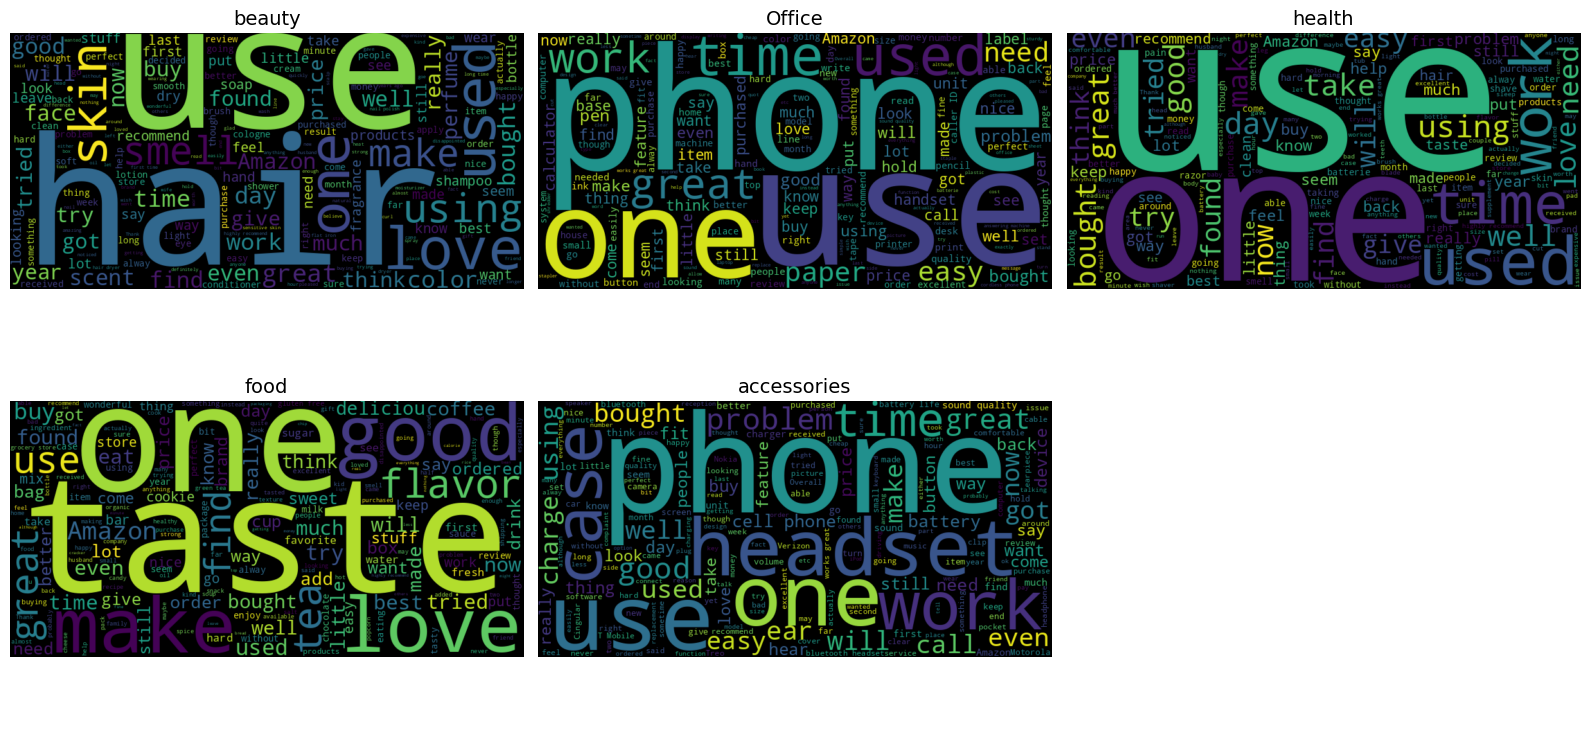

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm

# Baca hasil SBERT
df = pd.read_csv("SBERT_train.csv")

# Siapkan stopwords
stopwords = set(STOPWORDS)
stopwords.update(['produk', 'product'])

# Ambil kategori unik
categories = df['category'].unique()

# Setup grid plot
n_cols = 3
n_rows = (len(categories) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

# Loop dengan progress bar
for i, category in enumerate(tqdm(categories, desc="🧠 Generating WordClouds")):
    ax = axes[i]
    
    # Ambil komentar
    comments = df[df['category'] == category]['comment'].astype(str)
    text = " ".join(comments.tolist())

    # Buat WordCloud
    wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, colormap='viridis').generate(text)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(category, fontsize=14)
    ax.axis("off")

# Kosongkan subplot sisa
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
import numpy as np
import faiss
from tqdm import tqdm

# ⬅️ Load data hasil SBERT dari training set
df = pd.read_csv("SBERT_train.csv")

# Konversi kolom SBERT_Embedding dari string → list → array
import json
df['SBERT_Embedding'] = df['SBERT_Embedding'].apply(json.loads)

# Struktur penyimpanan index dan data
faiss_indexes = {}
category_embeddings = {}
category_df = {}

print("🚀 Building FAISS indexes per category...")

for category in tqdm(df['category'].unique(), desc="🔧 Build FAISS"):
    df_cat = df[df['category'] == category].reset_index(drop=True)
    if len(df_cat) < 10:
        continue
    embeds = np.array(df_cat['SBERT_Embedding'].tolist(), dtype='float32')
    faiss.normalize_L2(embeds)
    index = faiss.IndexFlatIP(embeds.shape[1])
    index.add(embeds)

    faiss_indexes[category] = index
    category_embeddings[category] = embeds
    category_df[category] = df_cat


🚀 Building FAISS indexes per category...


🔧 Build FAISS: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


In [15]:
# Load test data (yang akan dievaluasi)
df_test = pd.read_csv("SBERT_test.csv")
df_test['SBERT_Embedding'] = df_test['SBERT_Embedding'].apply(json.loads)

def evaluate_faiss_per_category(df, category_embeddings, category_df, faiss_indexes, top_k=10, sample_per_category=10):
    print("🔍 Evaluating FAISS-only Hit@K, Precision@K, Recall@K per category...\n")
    
    from tqdm import tqdm
    category_results = {}
    total_hit = 0
    total_precision = 0.0
    total_recall = 0.0
    total_samples = 0

    for category in tqdm(df['category'].unique(), desc="📁 Evaluating Categories"):
        if category not in faiss_indexes:
            continue

        df_cat_train = category_df[category]
        embeds_cat_train = category_embeddings[category]
        index = faiss_indexes[category]

        df_cat_test = df[df['category'] == category].reset_index(drop=True)
        
        effective_sample = min(sample_per_category, len(df_cat_test))

        sample_indices = np.random.choice(len(df_cat_test), size=effective_sample, replace=False)

        hits, count, precision_sum, recall_sum = 0, 0, 0.0, 0.0

        for idx in sample_indices:
            example = df_cat_test.iloc[idx]
            user_id = example['userID']
            true_items = set(df[df['userID'] == user_id]['productID'])

            if not true_items:
                continue

            query_vector = np.array(example['SBERT_Embedding'], dtype='float32').reshape(1, -1)
            faiss.normalize_L2(query_vector)

            D, I = index.search(query_vector, k=top_k + 1)
            rec_indices = [i for i in I[0] if i < len(df_cat_train)]
            rec_pids = [df_cat_train.iloc[i]['productID'] for i in rec_indices[:top_k]]

            relevant_retrieved = sum(pid in true_items for pid in rec_pids)

            hit = int(relevant_retrieved > 0)
            precision = relevant_retrieved / top_k
            recall = relevant_retrieved / len(true_items)
            recall = min(recall, 1.0)

            hits += hit
            precision_sum += precision
            recall_sum += recall
            count += 1

        if count > 0:
            hit_rate = hits / count
            precision_avg = precision_sum / count
            recall_avg = recall_sum / count

            category_results[category] = {
                "Hit@K": hit_rate,
                "Precision@K": precision_avg,
                "Recall@K": recall_avg,
                "Evaluated": count
            }

            total_hit += hits
            total_precision += precision_sum
            total_recall += recall_sum
            total_samples += count

            print(f"\n📂 Category: {category}")
            print(f"  ✅ Hit@{top_k}: {hit_rate:.2%}")
            print(f"  🎯 Precision@{top_k}: {precision_avg:.2%}")
            print(f"  📈 Recall@{top_k}: {recall_avg:.2%}")
            print(f"  🧪 Samples: {count}")

    if total_samples > 0:
        print("\n📊 === Overall Evaluation (TEST SET) ===")
        print(f"✅ Average Hit@{top_k}: {total_hit / total_samples:.2%}")
        print(f"🎯 Average Precision@{top_k}: {total_precision / total_samples:.2%}")
        print(f"📈 Average Recall@{top_k}: {total_recall / total_samples:.2%}")
    else:
        print("⚠️ No valid samples evaluated.")

    return category_results


In [7]:
import pandas as pd

df_test = pd.read_csv("SBERT_test.csv")
df_test['category'].value_counts()

health         64106
beauty         37385
food           23324
Office         21006
accessories    11781
Name: category, dtype: int64

In [8]:
import json

df_test = pd.read_csv("SBERT_test.csv")
df_test['SBERT_Embedding'] = df_test['SBERT_Embedding'].apply(json.loads)

# Jalankan evaluasi dengan test set
results = evaluate_faiss_per_category(
    df=df_test,
    category_embeddings=category_embeddings,
    category_df=category_df,
    faiss_indexes=faiss_indexes,
    top_k=10,
    sample_per_category=50000
)

🔍 Evaluating FAISS-only Hit@K, Precision@K, Recall@K per category...



📁 Evaluating Categories:  20%|██        | 1/5 [31:42<2:06:50, 1902.61s/it]


📂 Category: health
  ✅ Hit@10: 87.12%
  🎯 Precision@10: 61.55%
  📈 Recall@10: 83.68%
  🧪 Samples: 50000


📁 Evaluating Categories:  40%|████      | 2/5 [48:47<1:09:18, 1386.26s/it]


📂 Category: beauty
  ✅ Hit@10: 82.54%
  🎯 Precision@10: 51.88%
  📈 Recall@10: 78.82%
  🧪 Samples: 37385


📁 Evaluating Categories:  60%|██████    | 3/5 [57:12<32:48, 984.09s/it]   


📂 Category: food
  ✅ Hit@10: 86.09%
  🎯 Precision@10: 54.43%
  📈 Recall@10: 82.96%
  🧪 Samples: 23324


📁 Evaluating Categories:  80%|████████  | 4/5 [1:04:14<12:42, 762.13s/it]


📂 Category: Office
  ✅ Hit@10: 88.92%
  🎯 Precision@10: 58.47%
  📈 Recall@10: 83.92%
  🧪 Samples: 21006


📁 Evaluating Categories: 100%|██████████| 5/5 [1:07:31<00:00, 810.28s/it]


📂 Category: accessories
  ✅ Hit@10: 89.87%
  🎯 Precision@10: 63.47%
  📈 Recall@10: 86.55%
  🧪 Samples: 11781

📊 === Overall Evaluation (TEST SET) ===
✅ Average Hit@10: 86.25%
🎯 Average Precision@10: 57.58%
📈 Average Recall@10: 82.57%


In [17]:
# =============================
# 🚀 [NCF] TRAINING WITH DYNAMIC NEGATIVE (MAX 5 PER USER, LESS IF USER ACTIVE)
# =============================

import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
import json
from tqdm import tqdm

# Aktifkan tqdm
tqdm.pandas()

def load_data(path):
    print(f"\n📂 Loading file: {path}")
    df = pd.read_csv(path)
    print("🔄 Parsing SBERT Embedding...")
    df['SBERT_Embedding'] = df['SBERT_Embedding'].progress_apply(json.loads)
    return df

def get_dynamic_neg_count(n_pos, min_neg=1, max_neg=5):
    """
    Negative count per user, inversely proportional to positive count, capped at max_neg.
    - Sedikit positif: negative lebih banyak (maks 5)
    - Banyak positif: negative sedikit (min 1)
    """
    if n_pos < 3:
        return max_neg
    elif n_pos < 6:
        return 4
    elif n_pos < 10:
        return 3
    elif n_pos < 30:
        return 2
    else:
        return min_neg

def generate_train_df_dynamic(df):
    pos_df = df[['userID', 'productID']].copy()
    pos_df['label'] = 1

    user_to_items = df.groupby('userID')['productID'].apply(set).to_dict()
    all_items = set(df['productID'])

    negatives = []
    print("🔄 Generating dynamic negative samples (max 5 per user, fewer if user active)...")
    for idx, (user_id, interacted) in enumerate(user_to_items.items()):
        if idx % 100 == 0:
            print(f"  ➤ Processing user {idx + 1}/{len(user_to_items)}")

        negative_candidates = list(all_items - interacted)
        if not negative_candidates:
            continue

        neg_count = min(len(negative_candidates), get_dynamic_neg_count(len(interacted)))
        if neg_count == 0:
            continue

        sampled = random.sample(negative_candidates, neg_count)
        for item_id in sampled:
            negatives.append({'userID': user_id, 'productID': item_id, 'label': 0})

    neg_df = pd.DataFrame(negatives)
    return shuffle(pd.concat([pos_df, neg_df], ignore_index=True))

def encode_index(df, user_to_idx, item_to_idx):
    df['user_idx'] = df['userID'].map(user_to_idx)
    df['item_idx'] = df['productID'].map(item_to_idx)
    return df

# === Load Data ===
df_train = generate_train_df_dynamic(load_data("SBERT_train.csv"))
df_val = generate_train_df_dynamic(load_data("SBERT_val.csv"))

# === Index Mapping ===
all_users = pd.concat([df_train, df_val])['userID'].unique()
all_items = pd.concat([df_train, df_val])['productID'].unique()
user_to_idx = {u: i for i, u in enumerate(all_users)}
item_to_idx = {i: j for j, i in enumerate(all_items)}

df_train = encode_index(df_train, user_to_idx, item_to_idx)
df_val = encode_index(df_val, user_to_idx, item_to_idx)

X_train = [df_train['user_idx'].values, df_train['item_idx'].values]
y_train = df_train['label'].values
X_val = [df_val['user_idx'].values, df_val['item_idx'].values]
y_val = df_val['label'].values

# === Build NCF Model (STRONG REGULARIZATION) ===
embedding_dim = 64
num_users = len(user_to_idx)
num_items = len(item_to_idx)

l2_reg = regularizers.l2(1e-4)  # Lebih ketat

u_input = layers.Input(shape=(), dtype='int32', name='user')
i_input = layers.Input(shape=(), dtype='int32', name='item')

u_embed = layers.Embedding(num_users, embedding_dim, embeddings_regularizer=l2_reg)(u_input)
i_embed = layers.Embedding(num_items, embedding_dim, embeddings_regularizer=l2_reg)(i_input)

u_vec = layers.Flatten()(u_embed)
i_vec = layers.Flatten()(i_embed)

x = layers.Concatenate()([u_vec, i_vec])
x = layers.Dense(128, activation='relu', kernel_regularizer=l2_reg)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=l2_reg)(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(1, activation='sigmoid')(x)

ncf_model = Model(inputs=[u_input, i_input], outputs=out)
ncf_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# === Train Model ===
print("\n🚀 Training NCF model with dynamic negative sampling (max 5 per user) & strong regularization ...")
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ncf_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    shuffle=True,
    verbose=2,
    callbacks=[early_stop]
)

# === Save Model & Index Mapping ===
print("\n💾 Saving model and mappings...")
ncf_model.save("ncf_model.keras")
pd.Series(user_to_idx).to_csv("user_index.csv")
pd.Series(item_to_idx).to_csv("item_index.csv")
print("✅ Model & index mapping saved.")



📂 Loading file: SBERT_train.csv
🔄 Parsing SBERT Embedding...


100%|██████████| 735474/735474 [02:02<00:00, 6028.20it/s]


🔄 Generating dynamic negative samples (max 5 per user, fewer if user active)...
  ➤ Processing user 1/511684
  ➤ Processing user 101/511684
  ➤ Processing user 201/511684
  ➤ Processing user 301/511684
  ➤ Processing user 401/511684
  ➤ Processing user 501/511684
  ➤ Processing user 601/511684
  ➤ Processing user 701/511684
  ➤ Processing user 801/511684
  ➤ Processing user 901/511684
  ➤ Processing user 1001/511684
  ➤ Processing user 1101/511684
  ➤ Processing user 1201/511684
  ➤ Processing user 1301/511684
  ➤ Processing user 1401/511684
  ➤ Processing user 1501/511684
  ➤ Processing user 1601/511684
  ➤ Processing user 1701/511684
  ➤ Processing user 1801/511684
  ➤ Processing user 1901/511684
  ➤ Processing user 2001/511684
  ➤ Processing user 2101/511684
  ➤ Processing user 2201/511684
  ➤ Processing user 2301/511684
  ➤ Processing user 2401/511684
  ➤ Processing user 2501/511684
  ➤ Processing user 2601/511684
  ➤ Processing user 2701/511684
  ➤ Processing user 2801/511684
  ➤ 

  ➤ Processing user 25001/511684
  ➤ Processing user 25101/511684
  ➤ Processing user 25201/511684
  ➤ Processing user 25301/511684
  ➤ Processing user 25401/511684
  ➤ Processing user 25501/511684
  ➤ Processing user 25601/511684
  ➤ Processing user 25701/511684
  ➤ Processing user 25801/511684
  ➤ Processing user 25901/511684
  ➤ Processing user 26001/511684
  ➤ Processing user 26101/511684
  ➤ Processing user 26201/511684
  ➤ Processing user 26301/511684
  ➤ Processing user 26401/511684
  ➤ Processing user 26501/511684
  ➤ Processing user 26601/511684
  ➤ Processing user 26701/511684
  ➤ Processing user 26801/511684
  ➤ Processing user 26901/511684
  ➤ Processing user 27001/511684
  ➤ Processing user 27101/511684
  ➤ Processing user 27201/511684
  ➤ Processing user 27301/511684
  ➤ Processing user 27401/511684
  ➤ Processing user 27501/511684
  ➤ Processing user 27601/511684
  ➤ Processing user 27701/511684
  ➤ Processing user 27801/511684
  ➤ Processing user 27901/511684
  ➤ Proces

  ➤ Processing user 49901/511684
  ➤ Processing user 50001/511684
  ➤ Processing user 50101/511684
  ➤ Processing user 50201/511684
  ➤ Processing user 50301/511684
  ➤ Processing user 50401/511684
  ➤ Processing user 50501/511684
  ➤ Processing user 50601/511684
  ➤ Processing user 50701/511684
  ➤ Processing user 50801/511684
  ➤ Processing user 50901/511684
  ➤ Processing user 51001/511684
  ➤ Processing user 51101/511684
  ➤ Processing user 51201/511684
  ➤ Processing user 51301/511684
  ➤ Processing user 51401/511684
  ➤ Processing user 51501/511684
  ➤ Processing user 51601/511684
  ➤ Processing user 51701/511684
  ➤ Processing user 51801/511684
  ➤ Processing user 51901/511684
  ➤ Processing user 52001/511684
  ➤ Processing user 52101/511684
  ➤ Processing user 52201/511684
  ➤ Processing user 52301/511684
  ➤ Processing user 52401/511684
  ➤ Processing user 52501/511684
  ➤ Processing user 52601/511684
  ➤ Processing user 52701/511684
  ➤ Processing user 52801/511684
  ➤ Proces

  ➤ Processing user 74801/511684
  ➤ Processing user 74901/511684
  ➤ Processing user 75001/511684
  ➤ Processing user 75101/511684
  ➤ Processing user 75201/511684
  ➤ Processing user 75301/511684
  ➤ Processing user 75401/511684
  ➤ Processing user 75501/511684
  ➤ Processing user 75601/511684
  ➤ Processing user 75701/511684
  ➤ Processing user 75801/511684
  ➤ Processing user 75901/511684
  ➤ Processing user 76001/511684
  ➤ Processing user 76101/511684
  ➤ Processing user 76201/511684
  ➤ Processing user 76301/511684
  ➤ Processing user 76401/511684
  ➤ Processing user 76501/511684
  ➤ Processing user 76601/511684
  ➤ Processing user 76701/511684
  ➤ Processing user 76801/511684
  ➤ Processing user 76901/511684
  ➤ Processing user 77001/511684
  ➤ Processing user 77101/511684
  ➤ Processing user 77201/511684
  ➤ Processing user 77301/511684
  ➤ Processing user 77401/511684
  ➤ Processing user 77501/511684
  ➤ Processing user 77601/511684
  ➤ Processing user 77701/511684
  ➤ Proces

  ➤ Processing user 99701/511684
  ➤ Processing user 99801/511684
  ➤ Processing user 99901/511684
  ➤ Processing user 100001/511684
  ➤ Processing user 100101/511684
  ➤ Processing user 100201/511684
  ➤ Processing user 100301/511684
  ➤ Processing user 100401/511684
  ➤ Processing user 100501/511684
  ➤ Processing user 100601/511684
  ➤ Processing user 100701/511684
  ➤ Processing user 100801/511684
  ➤ Processing user 100901/511684
  ➤ Processing user 101001/511684
  ➤ Processing user 101101/511684
  ➤ Processing user 101201/511684
  ➤ Processing user 101301/511684
  ➤ Processing user 101401/511684
  ➤ Processing user 101501/511684
  ➤ Processing user 101601/511684
  ➤ Processing user 101701/511684
  ➤ Processing user 101801/511684
  ➤ Processing user 101901/511684
  ➤ Processing user 102001/511684
  ➤ Processing user 102101/511684
  ➤ Processing user 102201/511684
  ➤ Processing user 102301/511684
  ➤ Processing user 102401/511684
  ➤ Processing user 102501/511684
  ➤ Processing us

  ➤ Processing user 123901/511684
  ➤ Processing user 124001/511684
  ➤ Processing user 124101/511684
  ➤ Processing user 124201/511684
  ➤ Processing user 124301/511684
  ➤ Processing user 124401/511684
  ➤ Processing user 124501/511684
  ➤ Processing user 124601/511684
  ➤ Processing user 124701/511684
  ➤ Processing user 124801/511684
  ➤ Processing user 124901/511684
  ➤ Processing user 125001/511684
  ➤ Processing user 125101/511684
  ➤ Processing user 125201/511684
  ➤ Processing user 125301/511684
  ➤ Processing user 125401/511684
  ➤ Processing user 125501/511684
  ➤ Processing user 125601/511684
  ➤ Processing user 125701/511684
  ➤ Processing user 125801/511684
  ➤ Processing user 125901/511684
  ➤ Processing user 126001/511684
  ➤ Processing user 126101/511684
  ➤ Processing user 126201/511684
  ➤ Processing user 126301/511684
  ➤ Processing user 126401/511684
  ➤ Processing user 126501/511684
  ➤ Processing user 126601/511684
  ➤ Processing user 126701/511684
  ➤ Processing

  ➤ Processing user 148001/511684
  ➤ Processing user 148101/511684
  ➤ Processing user 148201/511684
  ➤ Processing user 148301/511684
  ➤ Processing user 148401/511684
  ➤ Processing user 148501/511684
  ➤ Processing user 148601/511684
  ➤ Processing user 148701/511684
  ➤ Processing user 148801/511684
  ➤ Processing user 148901/511684
  ➤ Processing user 149001/511684
  ➤ Processing user 149101/511684
  ➤ Processing user 149201/511684
  ➤ Processing user 149301/511684
  ➤ Processing user 149401/511684
  ➤ Processing user 149501/511684
  ➤ Processing user 149601/511684
  ➤ Processing user 149701/511684
  ➤ Processing user 149801/511684
  ➤ Processing user 149901/511684
  ➤ Processing user 150001/511684
  ➤ Processing user 150101/511684
  ➤ Processing user 150201/511684
  ➤ Processing user 150301/511684
  ➤ Processing user 150401/511684
  ➤ Processing user 150501/511684
  ➤ Processing user 150601/511684
  ➤ Processing user 150701/511684
  ➤ Processing user 150801/511684
  ➤ Processing

  ➤ Processing user 172101/511684
  ➤ Processing user 172201/511684
  ➤ Processing user 172301/511684
  ➤ Processing user 172401/511684
  ➤ Processing user 172501/511684
  ➤ Processing user 172601/511684
  ➤ Processing user 172701/511684
  ➤ Processing user 172801/511684
  ➤ Processing user 172901/511684
  ➤ Processing user 173001/511684
  ➤ Processing user 173101/511684
  ➤ Processing user 173201/511684
  ➤ Processing user 173301/511684
  ➤ Processing user 173401/511684
  ➤ Processing user 173501/511684
  ➤ Processing user 173601/511684
  ➤ Processing user 173701/511684
  ➤ Processing user 173801/511684
  ➤ Processing user 173901/511684
  ➤ Processing user 174001/511684
  ➤ Processing user 174101/511684
  ➤ Processing user 174201/511684
  ➤ Processing user 174301/511684
  ➤ Processing user 174401/511684
  ➤ Processing user 174501/511684
  ➤ Processing user 174601/511684
  ➤ Processing user 174701/511684
  ➤ Processing user 174801/511684
  ➤ Processing user 174901/511684
  ➤ Processing

  ➤ Processing user 196201/511684
  ➤ Processing user 196301/511684
  ➤ Processing user 196401/511684
  ➤ Processing user 196501/511684
  ➤ Processing user 196601/511684
  ➤ Processing user 196701/511684
  ➤ Processing user 196801/511684
  ➤ Processing user 196901/511684
  ➤ Processing user 197001/511684
  ➤ Processing user 197101/511684
  ➤ Processing user 197201/511684
  ➤ Processing user 197301/511684
  ➤ Processing user 197401/511684
  ➤ Processing user 197501/511684
  ➤ Processing user 197601/511684
  ➤ Processing user 197701/511684
  ➤ Processing user 197801/511684
  ➤ Processing user 197901/511684
  ➤ Processing user 198001/511684
  ➤ Processing user 198101/511684
  ➤ Processing user 198201/511684
  ➤ Processing user 198301/511684
  ➤ Processing user 198401/511684
  ➤ Processing user 198501/511684
  ➤ Processing user 198601/511684
  ➤ Processing user 198701/511684
  ➤ Processing user 198801/511684
  ➤ Processing user 198901/511684
  ➤ Processing user 199001/511684
  ➤ Processing

  ➤ Processing user 220301/511684
  ➤ Processing user 220401/511684
  ➤ Processing user 220501/511684
  ➤ Processing user 220601/511684
  ➤ Processing user 220701/511684
  ➤ Processing user 220801/511684
  ➤ Processing user 220901/511684
  ➤ Processing user 221001/511684
  ➤ Processing user 221101/511684
  ➤ Processing user 221201/511684
  ➤ Processing user 221301/511684
  ➤ Processing user 221401/511684
  ➤ Processing user 221501/511684
  ➤ Processing user 221601/511684
  ➤ Processing user 221701/511684
  ➤ Processing user 221801/511684
  ➤ Processing user 221901/511684
  ➤ Processing user 222001/511684
  ➤ Processing user 222101/511684
  ➤ Processing user 222201/511684
  ➤ Processing user 222301/511684
  ➤ Processing user 222401/511684
  ➤ Processing user 222501/511684
  ➤ Processing user 222601/511684
  ➤ Processing user 222701/511684
  ➤ Processing user 222801/511684
  ➤ Processing user 222901/511684
  ➤ Processing user 223001/511684
  ➤ Processing user 223101/511684
  ➤ Processing

  ➤ Processing user 244401/511684
  ➤ Processing user 244501/511684
  ➤ Processing user 244601/511684
  ➤ Processing user 244701/511684
  ➤ Processing user 244801/511684
  ➤ Processing user 244901/511684
  ➤ Processing user 245001/511684
  ➤ Processing user 245101/511684
  ➤ Processing user 245201/511684
  ➤ Processing user 245301/511684
  ➤ Processing user 245401/511684
  ➤ Processing user 245501/511684
  ➤ Processing user 245601/511684
  ➤ Processing user 245701/511684
  ➤ Processing user 245801/511684
  ➤ Processing user 245901/511684
  ➤ Processing user 246001/511684
  ➤ Processing user 246101/511684
  ➤ Processing user 246201/511684
  ➤ Processing user 246301/511684
  ➤ Processing user 246401/511684
  ➤ Processing user 246501/511684
  ➤ Processing user 246601/511684
  ➤ Processing user 246701/511684
  ➤ Processing user 246801/511684
  ➤ Processing user 246901/511684
  ➤ Processing user 247001/511684
  ➤ Processing user 247101/511684
  ➤ Processing user 247201/511684
  ➤ Processing

  ➤ Processing user 268501/511684
  ➤ Processing user 268601/511684
  ➤ Processing user 268701/511684
  ➤ Processing user 268801/511684
  ➤ Processing user 268901/511684
  ➤ Processing user 269001/511684
  ➤ Processing user 269101/511684
  ➤ Processing user 269201/511684
  ➤ Processing user 269301/511684
  ➤ Processing user 269401/511684
  ➤ Processing user 269501/511684
  ➤ Processing user 269601/511684
  ➤ Processing user 269701/511684
  ➤ Processing user 269801/511684
  ➤ Processing user 269901/511684
  ➤ Processing user 270001/511684
  ➤ Processing user 270101/511684
  ➤ Processing user 270201/511684
  ➤ Processing user 270301/511684
  ➤ Processing user 270401/511684
  ➤ Processing user 270501/511684
  ➤ Processing user 270601/511684
  ➤ Processing user 270701/511684
  ➤ Processing user 270801/511684
  ➤ Processing user 270901/511684
  ➤ Processing user 271001/511684
  ➤ Processing user 271101/511684
  ➤ Processing user 271201/511684
  ➤ Processing user 271301/511684
  ➤ Processing

  ➤ Processing user 292601/511684
  ➤ Processing user 292701/511684
  ➤ Processing user 292801/511684
  ➤ Processing user 292901/511684
  ➤ Processing user 293001/511684
  ➤ Processing user 293101/511684
  ➤ Processing user 293201/511684
  ➤ Processing user 293301/511684
  ➤ Processing user 293401/511684
  ➤ Processing user 293501/511684
  ➤ Processing user 293601/511684
  ➤ Processing user 293701/511684
  ➤ Processing user 293801/511684
  ➤ Processing user 293901/511684
  ➤ Processing user 294001/511684
  ➤ Processing user 294101/511684
  ➤ Processing user 294201/511684
  ➤ Processing user 294301/511684
  ➤ Processing user 294401/511684
  ➤ Processing user 294501/511684
  ➤ Processing user 294601/511684
  ➤ Processing user 294701/511684
  ➤ Processing user 294801/511684
  ➤ Processing user 294901/511684
  ➤ Processing user 295001/511684
  ➤ Processing user 295101/511684
  ➤ Processing user 295201/511684
  ➤ Processing user 295301/511684
  ➤ Processing user 295401/511684
  ➤ Processing

  ➤ Processing user 316701/511684
  ➤ Processing user 316801/511684
  ➤ Processing user 316901/511684
  ➤ Processing user 317001/511684
  ➤ Processing user 317101/511684
  ➤ Processing user 317201/511684
  ➤ Processing user 317301/511684
  ➤ Processing user 317401/511684
  ➤ Processing user 317501/511684
  ➤ Processing user 317601/511684
  ➤ Processing user 317701/511684
  ➤ Processing user 317801/511684
  ➤ Processing user 317901/511684
  ➤ Processing user 318001/511684
  ➤ Processing user 318101/511684
  ➤ Processing user 318201/511684
  ➤ Processing user 318301/511684
  ➤ Processing user 318401/511684
  ➤ Processing user 318501/511684
  ➤ Processing user 318601/511684
  ➤ Processing user 318701/511684
  ➤ Processing user 318801/511684
  ➤ Processing user 318901/511684
  ➤ Processing user 319001/511684
  ➤ Processing user 319101/511684
  ➤ Processing user 319201/511684
  ➤ Processing user 319301/511684
  ➤ Processing user 319401/511684
  ➤ Processing user 319501/511684
  ➤ Processing

  ➤ Processing user 340801/511684
  ➤ Processing user 340901/511684
  ➤ Processing user 341001/511684
  ➤ Processing user 341101/511684
  ➤ Processing user 341201/511684
  ➤ Processing user 341301/511684
  ➤ Processing user 341401/511684
  ➤ Processing user 341501/511684
  ➤ Processing user 341601/511684
  ➤ Processing user 341701/511684
  ➤ Processing user 341801/511684
  ➤ Processing user 341901/511684
  ➤ Processing user 342001/511684
  ➤ Processing user 342101/511684
  ➤ Processing user 342201/511684
  ➤ Processing user 342301/511684
  ➤ Processing user 342401/511684
  ➤ Processing user 342501/511684
  ➤ Processing user 342601/511684
  ➤ Processing user 342701/511684
  ➤ Processing user 342801/511684
  ➤ Processing user 342901/511684
  ➤ Processing user 343001/511684
  ➤ Processing user 343101/511684
  ➤ Processing user 343201/511684
  ➤ Processing user 343301/511684
  ➤ Processing user 343401/511684
  ➤ Processing user 343501/511684
  ➤ Processing user 343601/511684
  ➤ Processing

  ➤ Processing user 364901/511684
  ➤ Processing user 365001/511684
  ➤ Processing user 365101/511684
  ➤ Processing user 365201/511684
  ➤ Processing user 365301/511684
  ➤ Processing user 365401/511684
  ➤ Processing user 365501/511684
  ➤ Processing user 365601/511684
  ➤ Processing user 365701/511684
  ➤ Processing user 365801/511684
  ➤ Processing user 365901/511684
  ➤ Processing user 366001/511684
  ➤ Processing user 366101/511684
  ➤ Processing user 366201/511684
  ➤ Processing user 366301/511684
  ➤ Processing user 366401/511684
  ➤ Processing user 366501/511684
  ➤ Processing user 366601/511684
  ➤ Processing user 366701/511684
  ➤ Processing user 366801/511684
  ➤ Processing user 366901/511684
  ➤ Processing user 367001/511684
  ➤ Processing user 367101/511684
  ➤ Processing user 367201/511684
  ➤ Processing user 367301/511684
  ➤ Processing user 367401/511684
  ➤ Processing user 367501/511684
  ➤ Processing user 367601/511684
  ➤ Processing user 367701/511684
  ➤ Processing

  ➤ Processing user 389001/511684
  ➤ Processing user 389101/511684
  ➤ Processing user 389201/511684
  ➤ Processing user 389301/511684
  ➤ Processing user 389401/511684
  ➤ Processing user 389501/511684
  ➤ Processing user 389601/511684
  ➤ Processing user 389701/511684
  ➤ Processing user 389801/511684
  ➤ Processing user 389901/511684
  ➤ Processing user 390001/511684
  ➤ Processing user 390101/511684
  ➤ Processing user 390201/511684
  ➤ Processing user 390301/511684
  ➤ Processing user 390401/511684
  ➤ Processing user 390501/511684
  ➤ Processing user 390601/511684
  ➤ Processing user 390701/511684
  ➤ Processing user 390801/511684
  ➤ Processing user 390901/511684
  ➤ Processing user 391001/511684
  ➤ Processing user 391101/511684
  ➤ Processing user 391201/511684
  ➤ Processing user 391301/511684
  ➤ Processing user 391401/511684
  ➤ Processing user 391501/511684
  ➤ Processing user 391601/511684
  ➤ Processing user 391701/511684
  ➤ Processing user 391801/511684
  ➤ Processing

  ➤ Processing user 413101/511684
  ➤ Processing user 413201/511684
  ➤ Processing user 413301/511684
  ➤ Processing user 413401/511684
  ➤ Processing user 413501/511684
  ➤ Processing user 413601/511684
  ➤ Processing user 413701/511684
  ➤ Processing user 413801/511684
  ➤ Processing user 413901/511684
  ➤ Processing user 414001/511684
  ➤ Processing user 414101/511684
  ➤ Processing user 414201/511684
  ➤ Processing user 414301/511684
  ➤ Processing user 414401/511684
  ➤ Processing user 414501/511684
  ➤ Processing user 414601/511684
  ➤ Processing user 414701/511684
  ➤ Processing user 414801/511684
  ➤ Processing user 414901/511684
  ➤ Processing user 415001/511684
  ➤ Processing user 415101/511684
  ➤ Processing user 415201/511684
  ➤ Processing user 415301/511684
  ➤ Processing user 415401/511684
  ➤ Processing user 415501/511684
  ➤ Processing user 415601/511684
  ➤ Processing user 415701/511684
  ➤ Processing user 415801/511684
  ➤ Processing user 415901/511684
  ➤ Processing

  ➤ Processing user 437201/511684
  ➤ Processing user 437301/511684
  ➤ Processing user 437401/511684
  ➤ Processing user 437501/511684
  ➤ Processing user 437601/511684
  ➤ Processing user 437701/511684
  ➤ Processing user 437801/511684
  ➤ Processing user 437901/511684
  ➤ Processing user 438001/511684
  ➤ Processing user 438101/511684
  ➤ Processing user 438201/511684
  ➤ Processing user 438301/511684
  ➤ Processing user 438401/511684
  ➤ Processing user 438501/511684
  ➤ Processing user 438601/511684
  ➤ Processing user 438701/511684
  ➤ Processing user 438801/511684
  ➤ Processing user 438901/511684
  ➤ Processing user 439001/511684
  ➤ Processing user 439101/511684
  ➤ Processing user 439201/511684
  ➤ Processing user 439301/511684
  ➤ Processing user 439401/511684
  ➤ Processing user 439501/511684
  ➤ Processing user 439601/511684
  ➤ Processing user 439701/511684
  ➤ Processing user 439801/511684
  ➤ Processing user 439901/511684
  ➤ Processing user 440001/511684
  ➤ Processing

  ➤ Processing user 461301/511684
  ➤ Processing user 461401/511684
  ➤ Processing user 461501/511684
  ➤ Processing user 461601/511684
  ➤ Processing user 461701/511684
  ➤ Processing user 461801/511684
  ➤ Processing user 461901/511684
  ➤ Processing user 462001/511684
  ➤ Processing user 462101/511684
  ➤ Processing user 462201/511684
  ➤ Processing user 462301/511684
  ➤ Processing user 462401/511684
  ➤ Processing user 462501/511684
  ➤ Processing user 462601/511684
  ➤ Processing user 462701/511684
  ➤ Processing user 462801/511684
  ➤ Processing user 462901/511684
  ➤ Processing user 463001/511684
  ➤ Processing user 463101/511684
  ➤ Processing user 463201/511684
  ➤ Processing user 463301/511684
  ➤ Processing user 463401/511684
  ➤ Processing user 463501/511684
  ➤ Processing user 463601/511684
  ➤ Processing user 463701/511684
  ➤ Processing user 463801/511684
  ➤ Processing user 463901/511684
  ➤ Processing user 464001/511684
  ➤ Processing user 464101/511684
  ➤ Processing

  ➤ Processing user 485401/511684
  ➤ Processing user 485501/511684
  ➤ Processing user 485601/511684
  ➤ Processing user 485701/511684
  ➤ Processing user 485801/511684
  ➤ Processing user 485901/511684
  ➤ Processing user 486001/511684
  ➤ Processing user 486101/511684
  ➤ Processing user 486201/511684
  ➤ Processing user 486301/511684
  ➤ Processing user 486401/511684
  ➤ Processing user 486501/511684
  ➤ Processing user 486601/511684
  ➤ Processing user 486701/511684
  ➤ Processing user 486801/511684
  ➤ Processing user 486901/511684
  ➤ Processing user 487001/511684
  ➤ Processing user 487101/511684
  ➤ Processing user 487201/511684
  ➤ Processing user 487301/511684
  ➤ Processing user 487401/511684
  ➤ Processing user 487501/511684
  ➤ Processing user 487601/511684
  ➤ Processing user 487701/511684
  ➤ Processing user 487801/511684
  ➤ Processing user 487901/511684
  ➤ Processing user 488001/511684
  ➤ Processing user 488101/511684
  ➤ Processing user 488201/511684
  ➤ Processing

  ➤ Processing user 509501/511684
  ➤ Processing user 509601/511684
  ➤ Processing user 509701/511684
  ➤ Processing user 509801/511684
  ➤ Processing user 509901/511684
  ➤ Processing user 510001/511684
  ➤ Processing user 510101/511684
  ➤ Processing user 510201/511684
  ➤ Processing user 510301/511684
  ➤ Processing user 510401/511684
  ➤ Processing user 510501/511684
  ➤ Processing user 510601/511684
  ➤ Processing user 510701/511684
  ➤ Processing user 510801/511684
  ➤ Processing user 510901/511684
  ➤ Processing user 511001/511684
  ➤ Processing user 511101/511684
  ➤ Processing user 511201/511684
  ➤ Processing user 511301/511684
  ➤ Processing user 511401/511684
  ➤ Processing user 511501/511684
  ➤ Processing user 511601/511684

📂 Loading file: SBERT_val.csv
🔄 Parsing SBERT Embedding...


100%|██████████| 157602/157602 [00:25<00:00, 6130.78it/s]


🔄 Generating dynamic negative samples (max 5 per user, fewer if user active)...
  ➤ Processing user 1/135195
  ➤ Processing user 101/135195
  ➤ Processing user 201/135195
  ➤ Processing user 301/135195
  ➤ Processing user 401/135195
  ➤ Processing user 501/135195
  ➤ Processing user 601/135195
  ➤ Processing user 701/135195
  ➤ Processing user 801/135195
  ➤ Processing user 901/135195
  ➤ Processing user 1001/135195
  ➤ Processing user 1101/135195
  ➤ Processing user 1201/135195
  ➤ Processing user 1301/135195
  ➤ Processing user 1401/135195
  ➤ Processing user 1501/135195
  ➤ Processing user 1601/135195
  ➤ Processing user 1701/135195
  ➤ Processing user 1801/135195
  ➤ Processing user 1901/135195
  ➤ Processing user 2001/135195
  ➤ Processing user 2101/135195
  ➤ Processing user 2201/135195
  ➤ Processing user 2301/135195
  ➤ Processing user 2401/135195
  ➤ Processing user 2501/135195
  ➤ Processing user 2601/135195
  ➤ Processing user 2701/135195
  ➤ Processing user 2801/135195
  ➤ 

  ➤ Processing user 25001/135195
  ➤ Processing user 25101/135195
  ➤ Processing user 25201/135195
  ➤ Processing user 25301/135195
  ➤ Processing user 25401/135195
  ➤ Processing user 25501/135195
  ➤ Processing user 25601/135195
  ➤ Processing user 25701/135195
  ➤ Processing user 25801/135195
  ➤ Processing user 25901/135195
  ➤ Processing user 26001/135195
  ➤ Processing user 26101/135195
  ➤ Processing user 26201/135195
  ➤ Processing user 26301/135195
  ➤ Processing user 26401/135195
  ➤ Processing user 26501/135195
  ➤ Processing user 26601/135195
  ➤ Processing user 26701/135195
  ➤ Processing user 26801/135195
  ➤ Processing user 26901/135195
  ➤ Processing user 27001/135195
  ➤ Processing user 27101/135195
  ➤ Processing user 27201/135195
  ➤ Processing user 27301/135195
  ➤ Processing user 27401/135195
  ➤ Processing user 27501/135195
  ➤ Processing user 27601/135195
  ➤ Processing user 27701/135195
  ➤ Processing user 27801/135195
  ➤ Processing user 27901/135195
  ➤ Proces

  ➤ Processing user 50001/135195
  ➤ Processing user 50101/135195
  ➤ Processing user 50201/135195
  ➤ Processing user 50301/135195
  ➤ Processing user 50401/135195
  ➤ Processing user 50501/135195
  ➤ Processing user 50601/135195
  ➤ Processing user 50701/135195
  ➤ Processing user 50801/135195
  ➤ Processing user 50901/135195
  ➤ Processing user 51001/135195
  ➤ Processing user 51101/135195
  ➤ Processing user 51201/135195
  ➤ Processing user 51301/135195
  ➤ Processing user 51401/135195
  ➤ Processing user 51501/135195
  ➤ Processing user 51601/135195
  ➤ Processing user 51701/135195
  ➤ Processing user 51801/135195
  ➤ Processing user 51901/135195
  ➤ Processing user 52001/135195
  ➤ Processing user 52101/135195
  ➤ Processing user 52201/135195
  ➤ Processing user 52301/135195
  ➤ Processing user 52401/135195
  ➤ Processing user 52501/135195
  ➤ Processing user 52601/135195
  ➤ Processing user 52701/135195
  ➤ Processing user 52801/135195
  ➤ Processing user 52901/135195
  ➤ Proces

  ➤ Processing user 75001/135195
  ➤ Processing user 75101/135195
  ➤ Processing user 75201/135195
  ➤ Processing user 75301/135195
  ➤ Processing user 75401/135195
  ➤ Processing user 75501/135195
  ➤ Processing user 75601/135195
  ➤ Processing user 75701/135195
  ➤ Processing user 75801/135195
  ➤ Processing user 75901/135195
  ➤ Processing user 76001/135195
  ➤ Processing user 76101/135195
  ➤ Processing user 76201/135195
  ➤ Processing user 76301/135195
  ➤ Processing user 76401/135195
  ➤ Processing user 76501/135195
  ➤ Processing user 76601/135195
  ➤ Processing user 76701/135195
  ➤ Processing user 76801/135195
  ➤ Processing user 76901/135195
  ➤ Processing user 77001/135195
  ➤ Processing user 77101/135195
  ➤ Processing user 77201/135195
  ➤ Processing user 77301/135195
  ➤ Processing user 77401/135195
  ➤ Processing user 77501/135195
  ➤ Processing user 77601/135195
  ➤ Processing user 77701/135195
  ➤ Processing user 77801/135195
  ➤ Processing user 77901/135195
  ➤ Proces

  ➤ Processing user 100001/135195
  ➤ Processing user 100101/135195
  ➤ Processing user 100201/135195
  ➤ Processing user 100301/135195
  ➤ Processing user 100401/135195
  ➤ Processing user 100501/135195
  ➤ Processing user 100601/135195
  ➤ Processing user 100701/135195
  ➤ Processing user 100801/135195
  ➤ Processing user 100901/135195
  ➤ Processing user 101001/135195
  ➤ Processing user 101101/135195
  ➤ Processing user 101201/135195
  ➤ Processing user 101301/135195
  ➤ Processing user 101401/135195
  ➤ Processing user 101501/135195
  ➤ Processing user 101601/135195
  ➤ Processing user 101701/135195
  ➤ Processing user 101801/135195
  ➤ Processing user 101901/135195
  ➤ Processing user 102001/135195
  ➤ Processing user 102101/135195
  ➤ Processing user 102201/135195
  ➤ Processing user 102301/135195
  ➤ Processing user 102401/135195
  ➤ Processing user 102501/135195
  ➤ Processing user 102601/135195
  ➤ Processing user 102701/135195
  ➤ Processing user 102801/135195
  ➤ Processing

  ➤ Processing user 124201/135195
  ➤ Processing user 124301/135195
  ➤ Processing user 124401/135195
  ➤ Processing user 124501/135195
  ➤ Processing user 124601/135195
  ➤ Processing user 124701/135195
  ➤ Processing user 124801/135195
  ➤ Processing user 124901/135195
  ➤ Processing user 125001/135195
  ➤ Processing user 125101/135195
  ➤ Processing user 125201/135195
  ➤ Processing user 125301/135195
  ➤ Processing user 125401/135195
  ➤ Processing user 125501/135195
  ➤ Processing user 125601/135195
  ➤ Processing user 125701/135195
  ➤ Processing user 125801/135195
  ➤ Processing user 125901/135195
  ➤ Processing user 126001/135195
  ➤ Processing user 126101/135195
  ➤ Processing user 126201/135195
  ➤ Processing user 126301/135195
  ➤ Processing user 126401/135195
  ➤ Processing user 126501/135195
  ➤ Processing user 126601/135195
  ➤ Processing user 126701/135195
  ➤ Processing user 126801/135195
  ➤ Processing user 126901/135195
  ➤ Processing user 127001/135195
  ➤ Processing

2025-07-02 15:51:19.230175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-02 15:51:19.234593: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-02 15:51:19.236859: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-


🚀 Training NCF model with dynamic negative sampling (max 5 per user) & strong regularization ...
Epoch 1/20


2025-07-02 15:51:23.791074: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d7aac8532a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-02 15:51:23.791142: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-07-02 15:51:23.803282: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-02 15:51:23.839177: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90501
I0000 00:00:1751471483.936230     909 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101511/101511 - 996s - loss: 0.4830 - accuracy: 0.8394 - auc: 0.7557 - precision: 0.7713 - recall: 0.4130 - val_loss: 0.4730 - val_accuracy: 0.8374 - val_auc: 0.7276 - val_precision: 0.6033 - val_recall: 0.4203 - 996s/epoch - 10ms/step
Epoch 2/20
101511/101511 - 987s - loss: 0.4742 - accuracy: 0.8427 - auc: 0.7606 - precision: 0.7795 - recall: 0.4257 - val_loss: 0.4816 - val_accuracy: 0.8392 - val_auc: 0.7267 - val_precision: 0.6141 - val_recall: 0.4122 - 987s/epoch - 10ms/step
Epoch 3/20
101511/101511 - 979s - loss: 0.4744 - accuracy: 0.8426 - auc: 0.7601 - precision: 0.7848 - recall: 0.4203 - val_loss: 0.4755 - val_accuracy: 0.8370 - val_auc: 0.7243 - val_precision: 0.6017 - val_recall: 0.4196 - 979s/epoch - 10ms/step
Epoch 4/20
101511/101511 - 986s - loss: 0.4742 - accuracy: 0.8425 - auc: 0.7602 - precision: 0.7878 - recall: 0.4168 - val_loss: 0.4781 - val_accuracy: 0.8378 - val_auc: 0.7274 - val_precision: 0.6045 - val_recall: 0.4219 - 986s/epoch - 10ms/step
Epoch 5/20
101511/10151

In [18]:
# ============================
# 📊 [NCF] EVALUATION SCRIPT
# ============================

import pandas as pd
import numpy as np
import json
import random
import tensorflow as tf
from tqdm import tqdm

# === Load trained model and mappings ===
print("📦 Loading trained model and index mappings...")
ncf_model = tf.keras.models.load_model("ncf_model.keras")

# Load user/item index mapping
user_to_idx = pd.read_csv("user_index.csv", index_col=0, squeeze=True).to_dict()
item_to_idx = pd.read_csv("item_index.csv", index_col=0, squeeze=True).to_dict()

# === Load and preprocess test data ===
def load_data(path):
    print(f"\n📂 Loading file: {path}")
    df = pd.read_csv(path)
    df['SBERT_Embedding'] = df['SBERT_Embedding'].apply(json.loads)
    return df

def generate_test_df(df):
    print("🔄 Generating test data with negative samples...")
    pos_df = df[['userID', 'productID']].copy()
    pos_df['label'] = 1

    user_to_items = df.groupby('userID')['productID'].apply(set).to_dict()
    all_items = set(df['productID'])

    negatives = []
    for user_id, interacted in user_to_items.items():
        negative_candidates = list(all_items - interacted)
        if not negative_candidates:
            continue
        sampled = random.sample(negative_candidates, min(5, len(negative_candidates)))
        for item_id in sampled:
            negatives.append({'userID': user_id, 'productID': item_id, 'label': 0})

    neg_df = pd.DataFrame(negatives)
    return pd.concat([pos_df, neg_df], ignore_index=True)

def encode(df):
    df['user_idx'] = df['userID'].map(user_to_idx)
    df['item_idx'] = df['productID'].map(item_to_idx)
    # Hapus baris yang user/product-nya tidak dikenal
    df = df.dropna(subset=['user_idx', 'item_idx'])
    return df.astype({'user_idx': int, 'item_idx': int})

# === Run Evaluation ===
df_test_raw = load_data("SBERT_test.csv")
df_test = generate_test_df(df_test_raw)
df_test = encode(df_test)

X_test = [df_test['user_idx'].values, df_test['item_idx'].values]
y_test = df_test['label'].values

print("\n📊 Evaluating model on test set...")
results = ncf_model.evaluate(X_test, y_test, batch_size=256, verbose=2)

print("\n✅ Evaluation complete.")


📦 Loading trained model and index mappings...


/tmp/ipykernel_240/2401119429.py:17: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  user_to_idx = pd.read_csv("user_index.csv", index_col=0, squeeze=True).to_dict()
/tmp/ipykernel_240/2401119429.py:18: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  item_to_idx = pd.read_csv("item_index.csv", index_col=0, squeeze=True).to_dict()



📂 Loading file: SBERT_test.csv
🔄 Generating test data with negative samples...

📊 Evaluating model on test set...
1173/1173 - 5s - loss: 0.5129 - accuracy: 0.8117 - auc: 0.7430 - precision: 0.6366 - recall: 0.4575 - 5s/epoch - 4ms/step

✅ Evaluation complete.


In [34]:
import torch
import tensorflow as tf

print("=== 🔍 PyTorch Check ===")
print("Versi PyTorch:", torch.__version__)
print("CUDA tersedia:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("🖥️ PyTorch GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ PyTorch tidak mendeteksi GPU")

print("\n=== 🔍 TensorFlow Check ===")
print("Versi TensorFlow:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPU tersedia:", len(gpus) > 0)

if gpus:
    for i, gpu in enumerate(gpus):
        print(f"🖥️ TensorFlow GPU {i}: {gpu.name}")
else:
    print("⚠️ TensorFlow tidak mendeteksi GPU")


=== 🔍 PyTorch Check ===
Versi PyTorch: 2.5.1+cu121
CUDA tersedia: True
🖥️ PyTorch GPU: NVIDIA GeForce RTX 4080 SUPER

=== 🔍 TensorFlow Check ===
Versi TensorFlow: 2.15.0
GPU tersedia: True
🖥️ TensorFlow GPU 0: /physical_device:GPU:0


In [19]:
def evaluate_hybrid_hit_rate(user_to_idx, item_to_idx, idx_to_user, df, ncf_model, faiss_indexes, category_embeddings, category_df, k=10):
    from tqdm import tqdm
    import numpy as np

    total_hits = 0
    total_users_evaluated = 0
    total_precision = 0.0
    total_recall = 0.0

    print("🔍 Evaluating hybrid recommendations...")
    for user_id_test in tqdm(df['userID'].unique()[:150000], desc="📊 Evaluasi Hybrid"):
        # user_id_test sudah langsung dari df['userID'].unique(), tidak perlu mapping
        user_products = df[df['userID'] == user_id_test]
        true_items = set(user_products['productID'])

        if len(user_products) == 0 or len(true_items) == 0:
            continue

        top_category = user_products['category'].value_counts().idxmax()
        if top_category not in faiss_indexes:
            continue

        index = faiss_indexes[top_category]
        embeds_cat = category_embeddings[top_category]
        df_cat = category_df[top_category]

        embed_user = np.array(user_products['SBERT_Embedding'].tolist())
        user_vector = np.mean(embed_user, axis=0).reshape(1, -1).astype('float32')
        faiss.normalize_L2(user_vector)

        D, I = index.search(user_vector, k=10)
        candidate_idx = list(set(I[0]))

        candidate_pids = [df_cat.iloc[i]['productID'] for i in candidate_idx if df_cat.iloc[i]['productID'] in item_to_idx]
        if not candidate_pids:
            continue

        if user_id_test not in user_to_idx:
            continue
        user_tensor = np.array([user_to_idx[user_id_test]] * len(candidate_pids))
        item_tensor = np.array([item_to_idx[pid] for pid in candidate_pids])
        pred = ncf_model.predict([user_tensor, item_tensor], verbose=0)

        top_k_idx = np.argsort(pred.flatten())[::-1][:k]
        top_k_items = [candidate_pids[i] for i in top_k_idx]

        relevant_retrieved = sum(pid in true_items for pid in top_k_items)
        hit = int(relevant_retrieved > 0)
        precision = relevant_retrieved / k
        recall = min(relevant_retrieved / len(true_items), 1.0)

        total_hits += hit
        total_precision += precision
        total_recall += recall
        total_users_evaluated += 1

    if total_users_evaluated > 0:
        print("📊 === Hybrid Evaluation Results ===")
        print(f"✅ Hit@{k}: {total_hits / total_users_evaluated:.2%}")
        print(f"🎯 Precision@{k}: {total_precision / total_users_evaluated:.2%}")
        print(f"📈 Recall@{k}: {total_recall / total_users_evaluated:.2%}")
        print(f"👥 Total Users Evaluated: {total_users_evaluated}")
    else:
        print("⚠️ No users evaluated.")

In [20]:
# Jalankan hybrid evaluation
df_test_raw = load_data("SBERT_test.csv")
idx_to_user = {v: k for k, v in user_to_idx.items()}
evaluate_hybrid_hit_rate(user_to_idx, item_to_idx, idx_to_user, df_test_raw, ncf_model, faiss_indexes, category_embeddings, category_df, k=10)


📂 Loading file: SBERT_test.csv
🔍 Evaluating hybrid recommendations...


📊 Evaluasi Hybrid: 100%|██████████| 135145/135145 [2:32:21<00:00, 14.78it/s]  

📊 === Hybrid Evaluation Results ===
✅ Hit@10: 84.91%
🎯 Precision@10: 51.10%
📈 Recall@10: 83.38%
👥 Total Users Evaluated: 53427


In [27]:
import pandas as pd

df = pd.read_csv("SBERT_test.csv")
num_unique_users = df['userID'].nunique()
print(f"👥 Jumlah user unik di SBERT_test.csv: {num_unique_users}")

👥 Jumlah user unik di SBERT_test.csv: 135145
